In [4]:
import numpy as np
from numpy import concatenate
import pandas as pd
import tensorflow as tf
import keras
import math
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
import warnings
from plotly.offline import init_notebook_mode, iplot

In [7]:
solar_data = pd.read_csv('./data/train/train.csv',encoding='utf-8')

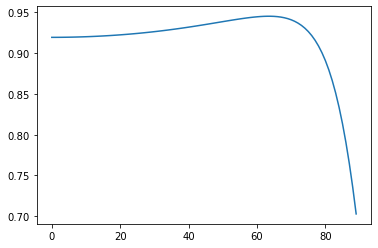

63 0.9451229383187134


In [8]:
corrList = []
corr = lambda p : p['TARGET'].corr(p['GHI'])

def makeCorrList(df):
    result = corr(df)
    corrList.append(result)

for i in range(0,90):
    solar_data['GHI'] = solar_data['DNI']*math.cos(math.pi/180*i)+solar_data['DHI']
    makeCorrList(solar_data)

x = np.arange(0,90)
plt.plot(x,corrList)
plt.show()

print(corrList.index(max(corrList)), max(corrList))

In [9]:
solar_data['GHI'] = solar_data['DNI']*math.cos(math.pi/180*63)+solar_data['DHI']

In [10]:
def eval_dewpoint(T, RH):
    b = 17.62
    c = 243.12
    gamma = (b * T / (c + T)) + math.log(RH / 100.0)
    dewpoint = (c * gamma) / (b - gamma)
    return dewpoint

In [11]:
for i in range(len(solar_data)):
    solar_data.loc[i, ["DP"]] = eval_dewpoint(float(solar_data.loc[i, ["T"]]), solar_data.loc[i , ["RH"]])

In [12]:
solar_data = solar_data.reindex(columns=["Day", "Hour", "Minute", "GHI", "DHI", "DNI", "WS", "RH", "T", "DP", "TARGET"])

In [13]:
solar_data.drop(['Day', 'Hour','Minute'], axis='columns', inplace=True)

In [14]:
train = solar_data
train

,GHI,DHI,DNI,WS,RH,T,DP,TARGET
0,0.0,0,0,1.5,69.08,-12,-16.522271,0.0
1,0.0,0,0,1.5,69.06,-12,-16.525742,0.0
2,0.0,0,0,1.6,71.78,-12,-16.061776,0.0
3,0.0,0,0,1.6,71.75,-12,-16.066807,0.0
4,0.0,0,0,1.6,75.20,-12,-15.500215,0.0
...,...,...,...,...,...,...,...,...
52555,0.0,0,0,2.4,70.70,-4,-8.540093,0.0
52556,0.0,0,0,2.4,66.79,-4,-9.268639,0.0
52557,0.0,0,0,2.2,66.78,-4,-9.270551,0.0
52558,0.0,0,0,2.1,67.72,-4,-9.091976,0.0


In [39]:
def get_sarima_params(train_data,train_exog):
    p=d=q=range(0,2)
    pdq = list(itertools.product(p,d,q))
    seasonal_pdq = [(x[0],x[1],x[2],48) for x in list(itertools.product(p,d,q))]
    result_table = pd.DataFrame(columns=['pda','seasonal_pda','aic'])
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
                print(param,param_seasonal,'testing')
                mod = sm.tsa.statespace.SARIMAX(train_data,exog=train_exog,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
                results = mod.fit()
                result_table = result_table.append({'pda':param, 'seasonal_pda':param_seasonal,'aic':results.aic},ignore_index=True)
    optimal_params = result_table[result_table['aic']==result_table.aic.min()]
    order = optimal_params.pda.values[0]
    seasonal_order = optimal_params.seasonal_pda.values[0]
    return (order,seasonal_order)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    train_data = pd.DataFrame(train['TARGET'])
    train_exog = train.loc[:,["GHI", "DHI", "DNI", "WS", "RH", "T", "DP"]]
    order, seasonal_arder = get_sarima_params(train_data,train_exog)
    print(order,seasonal_order)
    
    mod = sm.tsa.statespace.SARIMAX(train_data,exog=train_exog,order=order,seasonal_order=seasonal_order)
    results = mod.fit()
    pred=results.get_prediction(start=train_data.index[0],end=train_data.index[-1],exog=train_exog,dynamic=True)
    train_forecast=pred.predicted_mean.round()
    train_forecast[train_forecast<0]=0

(0, 0, 0) (0, 0, 0, 48) testing
(0, 0, 0) (0, 0, 1, 48) testing


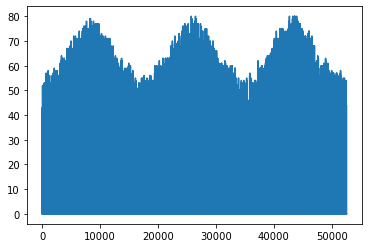

In [ ]:
results.summary()